In [45]:
import numpy as np
import aipy as a
from hera_cal import omni
import hera_qm.ant_metrics as ant_metrics
reload(ant_metrics)
from hera_cal.data import DATA_PATH
from hera_cal import io
from hera_cal.redcal import get_pos_reds
import sys

# Setup

In [46]:
verbose = True
pols = ['xx','xy','yx','yy']
JD = '2457757.47316'
dataFileList = [DATA_PATH + '/zen.2457698.40355.xx.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.yy.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.xy.HH.uvcA',
                DATA_PATH + '/zen.2457698.40355.yx.HH.uvcA']
freqs = np.arange(.1,.2,.1/1024)
sys.path.append(DATA_PATH)
aa = a.cal.get_aa('heratest_calfile', freqs)
info = omni.aa_to_info(aa, pols=[pols[-1][0]], crosspols=[pols[-1]])
reds = info.get_reds()
metricsJSONFilename = JD+'.metrics.json'

# Main script for computing and saving metrics

In [49]:
am = ant_metrics.Antenna_Metrics(dataFileList, reds, fileformat='miriad')
am.iterative_antenna_metrics_and_flagging(crossCut=5, deadCut=5, alwaysDeadCut=10, verbose=verbose)
am.save_antenna_metrics(metricsJSONFilename)

On iteration 0 we flag (81, 'x')
On iteration 1 we flag (81, 'y')


# Plotting

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_metric(metrics, ants=None, antpols=None, title='', ylabel='Modified z-Score', xlabel=''):
    '''Helper function for quickly plotting an individual antenna metric.'''

    if ants is None:
        ants = list(set([key[0] for key in metrics.keys()]))
    if antpols is None:
        antpols = list(set([key[1] for key in metrics.keys()]))

    for antpol in antpols:
        for i,ant in enumerate(ants):
            metric = 0
            if metrics.has_key((ant,antpol)):
                metric = metrics[(ant,antpol)]
            plt.plot(i,metric,'.')
            plt.annotate(str(ant)+antpol,xy=(i,metrics[(ant,antpol)]))
        plt.gca().set_prop_cycle(None)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

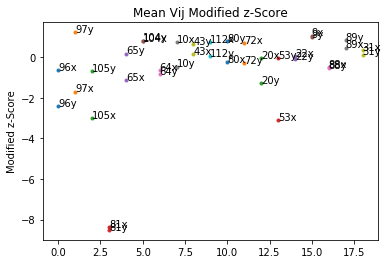

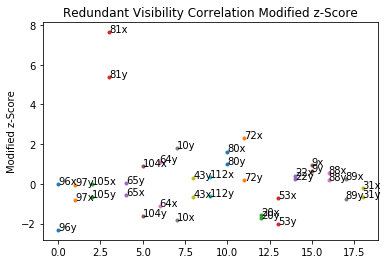

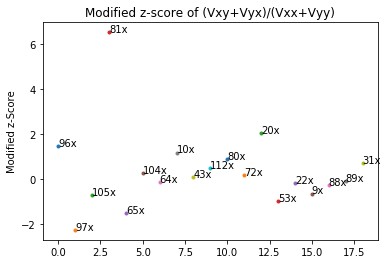

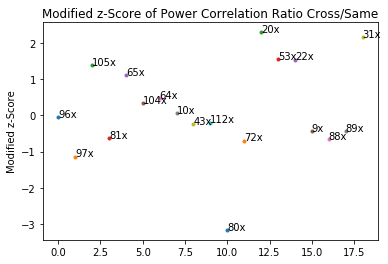

In [8]:
metrics_results = ant_metrics.load_antenna_metrics(metricsJSONFilename)

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['meanVij'], 
            title = 'Mean Vij Modified z-Score')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['redCorr'],
            title = 'Redundant Visibility Correlation Modified z-Score')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['meanVijXPol'], antpols=['x'],
            title = 'Modified z-score of (Vxy+Vyx)/(Vxx+Vyy)')

plt.figure()
plot_metric(metrics_results['final_mod_z_scores']['redCorrXPol'], antpols=['x'],
            title = 'Modified z-Score of Power Correlation Ratio Cross/Same')

In [5]:
import glob
amfiles = glob.glob('../../hera_sandbox/jsd/Antenna_Metrics/sample_jsons/*')
ams = [ant_metrics.load_antenna_metrics(f) for f in amfiles]

<IPython.core.display.Javascript object>


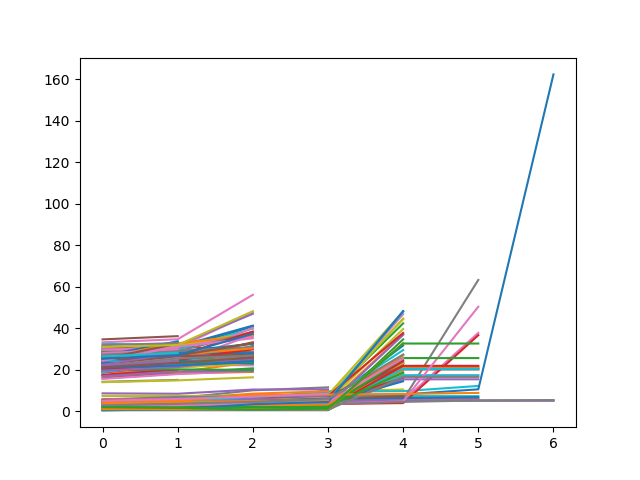

In [10]:
import matplotlib.pyplot as plt

below,above = 0,0

%matplotlib notebook
plt.figure()
for am in ams:
    for xant in am['dead_ants']:
        final_dead_metric = np.abs(am['final_mod_z_scores']['meanVij'][xant]/2) + np.abs(am['final_mod_z_scores']['redCorr'][xant]/2)
        progression = []
        for metrics in am['all_mod_z_scores']:
            try:
                progression.append(np.abs(metrics['meanVij'][xant]/2) + np.abs(metrics['redCorr'][xant]/2))
            except:
                pass
        plt.plot(progression)

In [16]:
test = {1,2,3}
test.add(10)
print test

set([1, 2, 3, 10])


# dead

In [44]:
import glob
amfiles = glob.glob('../../hera_sandbox/jsd/Antenna_Metrics/sample_jsons/*')
ams = [ant_metrics.load_antenna_metrics(f) for f in amfiles]

starts_below_10 = set([])
starts_above_10 = set([])
ends_above_5 = set([])
ends_below_5 = set([])

for n,am in enumerate(ams):
    for ant in am['final_mod_z_scores']['meanVij'].keys():
        final_dead_metric = np.abs(am['final_mod_z_scores']['meanVij'][ant]/2) + np.abs(am['final_mod_z_scores']['redCorr'][ant]/2)
        starting_dead_metric = np.abs(am['all_mod_z_scores'][0]['meanVij'][ant]/2) + np.abs(am['all_mod_z_scores'][0]['redCorr'][ant]/2)
        if final_dead_metric > 5:
            ends_above_5.add(ant+(n,))
        if final_dead_metric <= 5:
            ends_below_5.add(ant+(n,))
        if starting_dead_metric > 10:
            starts_above_10.add(ant+(n,))
        if starting_dead_metric <= 10:
            starts_below_10.add(ant+(n,))

print 'starts_below_10', len(starts_below_10)
print 'starts_above_10', len(starts_above_10)
print 'ends_below_5', len(ends_below_5)
print 'ends_above_5', len(ends_above_5)

print 'starts above 10 and ends below 5:', len(starts_above_10.intersection(ends_below_5))
print 'starts below 10 and ends above 5:', len(starts_above_10.intersection(ends_above_5))

starts_below_10 9000
starts_above_10 216
ends_below_5 8889
ends_above_5 327
starts above 10 and ends below 5: 0
starts below 10 and ends above 5: 216


# cross

In [42]:
starts_below_10 = set([])
starts_above_10 = set([])
ends_above_5 = set([])
ends_below_5 = set([])

for n,am in enumerate(ams):
    for ant in am['final_mod_z_scores']['meanVij'].keys():
        final_dead_metric = np.abs(am['final_mod_z_scores']['meanVijXPol'][ant]/2) + np.abs(am['final_mod_z_scores']['redCorrXPol'][ant]/2)
        starting_dead_metric = np.abs(am['all_mod_z_scores'][0]['meanVijXPol'][ant]/2) + np.abs(am['all_mod_z_scores'][0]['redCorrXPol'][ant]/2)
        if final_dead_metric > 5:
            ends_above_5.add(ant+(n,))
        if final_dead_metric <= 5:
            ends_below_5.add(ant+(n,))
        if starting_dead_metric > 10:
            starts_above_10.add(ant+(n,))
        if starting_dead_metric <= 10:
            starts_below_10.add(ant+(n,))

print 'starts_below_10', len(starts_below_10)
print 'starts_above_10', len(starts_above_10)
print 'ends_below_5', len(ends_below_5)
print 'ends_above_5', len(ends_above_5)

print len(starts_above_10.intersection(ends_below_5))
print len(starts_above_10.intersection(ends_above_5))

starts_below_10 9216
starts_above_10 0
ends_below_5 9092
ends_above_5 36
0
0
